# Machine Learning in Network Science
Final Project

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [49]:
from importlib import reload
reload(analyseData)
reload(loadData)

<module 'util.load_Data' from 'd:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\4_project\\Network-Science_Final-Project\\util\\load_Data.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.load_Data as loadData

In [2]:
# parse & handle data
import numpy as np
import pandas as pd
import networkx as nx # graph data

# dimensionaliy reduction
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# visualization
import matplotlib.pyplot as plt

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# load raw data
node_info, edgelist, class_to_idx_dict, idx_to_class_dict = loadData.load_raw()

# print shapes
print(node_info.shape)
print(edgelist.shape)

(2708, 1434)
(5429, 2)


### 3. Missing values, duplicates and find possible data leakage

#### 3.1 Edge lists

There are no duplicates in the dataset! (as in no edges where source and target node are the same)

In [5]:
# number of duplicates
print(edgelist.shape)
edgelist.duplicated(subset = ["source", "target"]).value_counts()

(5429, 2)


False    5429
dtype: int64

create our graph based on overall edgelist

In [6]:
# create graph
G = loadData.init_nx_graph(edgelist)

# number of isolated nodes
print(f"Number of isolated nodes: {len(list(nx.isolates(G)))}")

Number of isolated nodes: 0


#### 3.2 Node Information

In [7]:
# number of nodes per class
node_info.label.value_counts().sort_index()

0    298
1    418
2    818
3    426
4    217
5    180
6    351
Name: label, dtype: int64

In [8]:
# missing values
node_info.isnull().sum().sum()

0

In [9]:
# completely empty columns
empty_cols = node_info.columns[node_info.nunique() == 1].values
print(empty_cols)

# remove them from the dataframea
node_info = node_info.drop(columns = empty_cols, inplace = False)

[445]


In [10]:
# get dict of unique embeddings in our data
emb_dict = {}
emb_id = 0
for i in node_info.index:
    emb = tuple(node_info.loc[i].values)
    if emb not in emb_dict:
        emb_dict[emb] = emb_id
        emb_id += 1
print(f"Number of unique embeddings: {len(emb_dict)}")

Number of unique embeddings: 2692


In [11]:
# number of duplicates
print(node_info.shape)
node_info_tf = (node_info
    .assign(emb_id    = lambda df_: [emb_dict[tuple(df_.loc[i].values)] for i in df_.index])
    .assign(duplicate = lambda df_: df_.duplicated(keep = False))
)
node_info_tf.duplicate.value_counts()

(2708, 1433)


False    2681
True       27
Name: duplicate, dtype: int64

In [12]:
# show duplicated data grouped by unique embedding id
node_info_tf.loc[node_info_tf.duplicate == True].groupby("emb_id", group_keys = True).apply(lambda x: x)

1  2  3  4  5  6  7  8  9  10  ...  1427  1428  1429  1430  1431  \
emb_id node                                 ...                                 
166    166   0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2656  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2593   2593  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2598  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2625  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2597   2597  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2632  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2598   2599  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2615  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2700  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2600   2601  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2608  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2631  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2658  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2605   2606  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2655  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2702  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2607   2609  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2668  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2617   2620  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2667  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2636   2642  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2645  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2640   2647  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2659  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2678   2691  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2692  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   

             1432  1433  label  emb_id  duplicate  
emb_id node                                        
166    166      1     0      4     166       True  
       2656     1     0      4     166       True  
2593   2593     0     0      2    2593       True  
       2598     0     0      2    2593       True  
       2625     0     0      2    2593       True  
2597   2597     0     0      3    2597       True  
       2632     0     0      3    2597       True  
2598   2599     0     0      2    2598       True  
       2615     0     0      2    2598       True  
       2700     0     0      2    2598       True  
2600   2601     0     0      0    2600       True  
       2608     0     0      0    2600       True  
       2631     0     0      0    2600       True  
       2658     0     0      0    2600       True  
2605   2606     0     0      1    2605       True  
       2655     0     0      1    2605       True  
       2702     0     0      1    2605       True  
2607   2609     0     0      2    2607       True  
       2668     0     0      2    2607       True  
2617   2620     0     0      1    2617       True  
       2667     0     0      1    2617       True  
2636   2642     0     0      5    2636       True  
       2645     0     0      5    2636       True  
2640   2647     0     0      0    2640       True  
       2659     0     0      0    2640       True  
2678   2691     0     0      2    2678       True  
       2692     0     0      2    2678       True  

[27 rows x 1435 columns]

In [13]:
# number of unique embeddings in the duplicated data
node_info_tf.loc[node_info_tf.duplicate == True].emb_id.nunique()

11

In [14]:
# number of unique embeddings in the duplicated data
node_info_tf.loc[node_info_tf.duplicate == True].emb_id.value_counts().head(10)

2600    4
2593    3
2598    3
2605    3
166     2
2597    2
2607    2
2617    2
2636    2
2640    2
Name: emb_id, dtype: int64

only 27 node embeddings are pure duplicates (with 11 unique embeddings among the 27 vectors). But do they also have the same set of neighbours?

In [15]:
# get neighbors of each node
node_info_tf = (node_info_tf
    .assign(neighbors = lambda df_: [tuple(set([i for i in nx.all_neighbors(G, node)])) for node in df_.index]))

In [16]:
# show duplicated data that also have same neighbors grouped by unique embedding id
node_info_tf.loc[node_info_tf.duplicated(keep = False)].groupby("emb_id", group_keys = True).apply(lambda x: x)

1  2  3  4  5  6  7  8  9  10  ...  1428  1429  1430  1431  1432  \
emb_id node                                 ...                                 
2593   2593  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2598  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2625  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2597   2597  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2632  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2598   2599  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2615  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2700  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2600   2601  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2608  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2631  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2658  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2605   2606  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2655  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2702  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2607   2609  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2668  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2617   2620  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2667  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2636   2642  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2645  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2640   2647  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2659  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
2678   2691  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   
       2692  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     0     0   

             1433  label  emb_id  duplicate                      neighbors  
emb_id node                                                                 
2593   2593     0      2    2593       True                (464, 508, 509)  
       2598     0      2    2593       True                (464, 508, 509)  
       2625     0      2    2593       True                (464, 508, 509)  
2597   2597     0      3    2597       True                     (296, 749)  
       2632     0      3    2597       True                     (296, 749)  
2598   2599     0      2    2598       True            (453, 675, 381, 71)  
       2615     0      2    2598       True            (453, 675, 381, 71)  
       2700     0      2    2598       True            (453, 675, 381, 71)  
2600   2601     0      0    2600       True                (513, 131, 549)  
       2608     0      0    2600       True                (513, 131, 549)  
       2631     0      0    2600       True                (513, 131, 549)  
       2658     0      0    2600       True                (513, 131, 549)  
2605   2606     0      1    2605       True             (0, 809, 266, 822)  
       2655     0      1    2605       True             (0, 809, 266, 822)  
       2702     0      1    2605       True             (0, 809, 266, 822)  
2607   2609     0      2    2607       True               (1096, 233, 724)  
       2668     0      2    2607       True               (1096, 233, 724)  
2617   2620     0      1    2617       True               (498, 187, 1317)  
       2667     0      1    2617       True               (498, 187, 1317)  
2636   2642     0      5    2636       True                 (42, 70, 1038)  
       2645     0      5    2636       True                 (42, 70, 1038)  
2640   2647     0      0    2640       True           

25 of the 27 nodes have the same embedding as well as the same set of neighbors!

### 4. Graph Analysis

In [17]:
# get basic stats of network
prop = analyseData.compute_network_characteristics(graph = G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))
print("Avg. clustering coefficient: {}".format(prop['avg_clustering']))

Number of nodes: 2708
Number of edges: 5429
Min. degree: 1
Max. degree: 169
Mean degree: 4.0096011816839
Median degree: 3.0
Density: 0.0007405986667314184
Avg. clustering coefficient: 0.13138295104285608


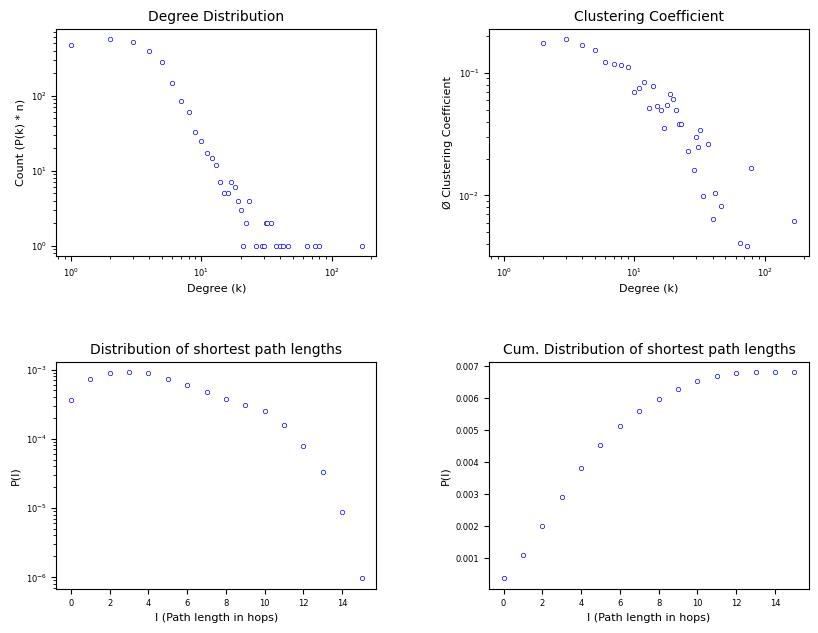

In [20]:
analyseData.plot_graph_stats(G)

### 5. Node embedding features

#### 5.1 Analysis of node embeddings

Let us first start by looking at the distribution of:
- the number of keywords per node
- the number of nodes per keyword

In [18]:
node_info_no_lbls = node_info.iloc[:, :-1]

In [39]:
kws_per_node = (node_info_no_lbls
    .assign(kws = lambda df_: [sorted(set([col + 1 for col, val in enumerate(df_.loc[i]) if val != 0])) for i in df_.index])
    .kws.to_frame()
    .assign(num_kws = lambda df_: [len(kw) for kw in df_.kws])
)

kws_per_node.head(3)

,kws,num_kws
node,,
0,"[20, 100, 141, 192, 386, 464, 495, 507, 580, 6...",20
1,"[126, 293, 495, 507, 629, 729, 759, 1005, 1075...",18
2,"[8, 264, 293, 332, 734, 972, 1004, 1132, 1151,...",12


In [40]:
nodes_per_kw = pd.DataFrame.from_dict(dict(node_info_no_lbls.sum().astype(int)), orient = "index", columns = ["num_nodes"])

nodes_per_kw.head(3)

,num_nodes
1,16
2,33
3,70


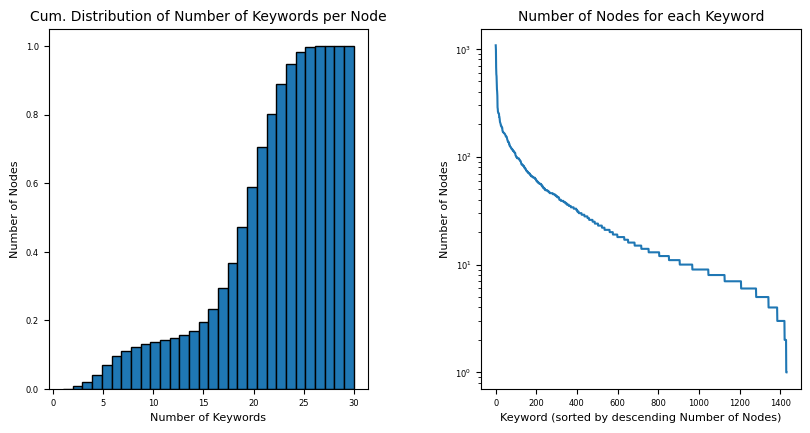

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.tight_layout(w_pad = 10)

kws_per_node.num_kws.hist(ax = ax[0], bins = max(kws_per_node.num_kws), edgecolor="black", grid = False,
                          cumulative = True, density = 1)
ax[0].set_xlabel("Number of Keywords")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Cum. Distribution of Number of Keywords per Node")

nodes_per_kw.num_nodes.sort_values(ascending = False).plot(ax = ax[1], kind = "line", use_index = False)
ax[1].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[1].set_ylabel("Number of Nodes")
ax[1].set_title("Number of Nodes for each Keyword")
ax[1].set_yscale("log")

Takeaways:
- 90% of nodes have more than 10 keywords
- 30% of keywords refer to less than 10 nodes

This is surprising as the README of the dataset specifies that "All words with document frequency less than 10 were removed." However, we can clearly see that nearly 500 keywords appear less than 10 times.

In consequence, some keywords are extremely common (and thus probably not very useful for separating keywords) while others are much more discriminative. In consequence, it might be a very good idea to transform this matrix using TF-IDF (but as we have only binary representation of keywords, it effectively becomes IDF as term frequency is either 1 or 0). Inverse Document Frequency means that rare keywords weigh more than frequent ones (which is exactly what we want).

In [45]:
node_info_idf = node_info_no_lbls.copy(deep = True)

for col in node_info_idf.columns:
    node_info_idf[col].loc[node_info_idf[col] == 1] = np.log(len(node_info_idf)/(1 + node_info_idf[col].sum()))

C:\Users\lasse\AppData\Local\Temp\ipykernel_16784\274786326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_info_idf[col].loc[node_info_idf[col] == 1] = np.log(len(node_info_idf)/(1 + node_info_idf[col].sum()))


In [46]:
nodes_per_kw["idf"] = node_info_idf.max()

Text(0.5, 1.0, 'IDF for each Keyword')

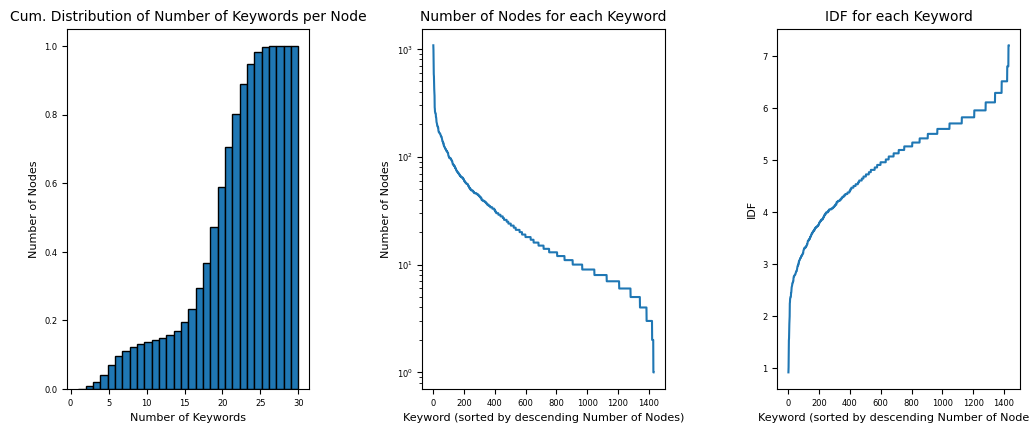

In [47]:
fig, ax = plt.subplots(1, 3, figsize = (10, 4))
fig.tight_layout(w_pad = 10)

kws_per_node.num_kws.hist(ax = ax[0], bins = max(kws_per_node.num_kws), edgecolor="black", grid = False,
                          cumulative = True, density = 1)
ax[0].set_xlabel("Number of Keywords")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Cum. Distribution of Number of Keywords per Node")

nodes_per_kw.sort_values(by = "num_nodes", ascending = False).num_nodes.plot(ax = ax[1], kind = "line", use_index = False)
ax[1].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[1].set_ylabel("Number of Nodes")
ax[1].set_title("Number of Nodes for each Keyword")
ax[1].set_yscale("log")

nodes_per_kw.sort_values(by = "num_nodes", ascending = False).idf.plot(ax = ax[2], kind = "line", use_index = False)
ax[2].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[2].set_ylabel("IDF")
ax[2].set_title("IDF for each Keyword")

#### 5.2 Decision Rules based on node embeddings

Two nodes (research papers) have an edge if the target quotes the source. In consequence, it might be a good idea to understand whether or not there are relations between the keywords (e.g. if the source paper has a keyword about new optimisation algorithms, then it might refer to previous optimisation papers). We will do this by finding underlying association rules with the apriori algorithm (just like in the market-basket analysis).

But how do we construct the decision rules? Our goal is link prediction and to build our decision rules we only care about the actual (positive) edges in our graph. Based on the existing edges, we will then built our baskets as follows: Basket = [keywords_source --> keywords source].

One important note: we have joined all key words from source and target into one big basket. This means, we might also extract decision rules for single nodes (e.g. if one node contains this keyword, it might also contain this keyword). For our task of link prediction, we will need to make sure later that we only consider decision rules that relate from one node to the other.

In [48]:
# get embeddings
embeddings = node_info_no_lbls

In [50]:
# get decision rules
_, rule_finder_dict, rule_values_dict = analyseData.get_decision_rules(G.edges(), embeddings)
len(rule_values_dict)

12972

In [51]:
# show first three decision rules
for count, (items, value_dict) in enumerate(rule_values_dict.items()):
    
    if count < 3:

        # rule
        print(f"Rule: {items[0]} -> {items[1]}")

        # properties of this rule
        print(f"Support: {value_dict['support']}")
        print(f"Confidence: {value_dict['confidence']}")
        print(f"Lift: {value_dict['lift']}")
        print("=====================================")

Rule: 40 -> 1
Support: 22.0
Confidence: 0.36666666666666664
Lift: 3.071851851851852
Rule: 1 -> 861
Support: 21.0
Confidence: 0.35
Lift: 3.4464552238805966
Rule: 1 -> 1398
Support: 20.0
Confidence: 0.3333333333333333
Lift: 3.5978186775732786


#### 5.3 Dimensionality Reduction of Node Embedding

Let us see if we can create a meaningful clustering based on the embeddings of each node. This is based on the intuition that nodes that share many keywords should likely belong to the same cluster (e.g. neural networks vs rule learning).

However, the embedding of each node is of very high dimension. Let us first try to reduce the dimensionality before clustering the data. First, I thought about using PCA -- however, for this problem it is probably a very bad idea. See below cell.

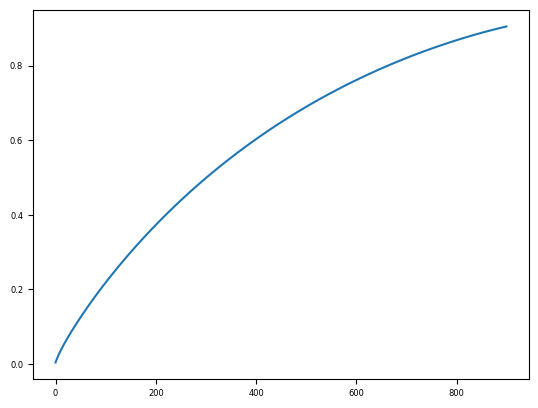

In [54]:
# create PCA embedding
n_components = []
explained_variance = []

# scale data
scaler = StandardScaler()

# perform pca
pca = PCA(n_components = 900)
pca.fit(scaler.fit_transform(node_info_idf))

# get embedding
embedding = PCA(n_components = 10).fit_transform(node_info_idf)

# look at explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)

We can see that PCA has a very hard time to explain the variance in the IDF-transformed embeddings (but also same for original binary features). Why? PCA can only find linear relations based on the global structure -- but in a very sparse binary matrix we will probably have many non-linear relations.

In addition, regarding the embedding itself, PCA has another problem: local neighborhoods are not preserved (far away points can become nearest neighbors in projected subspace).

However, we want to preserve local neighborhoods, at least to some extent. In consequence, we will use UMAP on the embeddings to create an embedding that preserves the local neighborhood.

In [23]:
# create umap embedding of nodes
reducer = umap.UMAP(metric = "cosine",
                    n_neighbors=10,
                    min_dist=0,
                    n_components=2).fit(node_info_no_lbls)

embedding = reducer.transform(node_info_no_lbls)

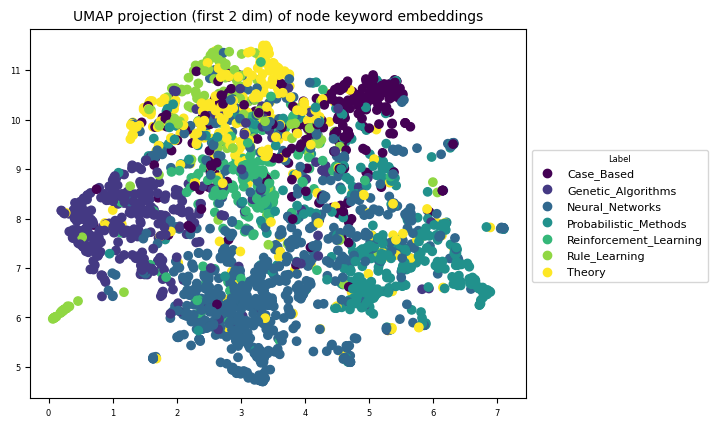

In [24]:
# plot umap embedding of nodes
fig, ax = plt.subplots()

scatter = ax.scatter(embedding[:, 0],
                     embedding[:, 1],
                     c = node_info.label,
                     label = list(idx_to_class_dict.keys())
)

# add formatting
handles, labels = scatter.legend_elements()
legend = ax.legend(handles, [idx_to_class_dict[idx] for idx in [int(label.split("{")[1].split("}")[0]) for label in labels]], loc = "lower left",
                   title = "Label", bbox_to_anchor = [1, 0.3])
ax.set_title('UMAP projection (first 2 dim) of node keyword embeddings')
plt.show()

We can see that the UMAP embeddings seem to already seperate quite well the different clusters. In consequence, we should be able to leverage the keyword embeddings to enhance our link prediction algorithms!